In [2]:


import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)



import matplotlib as mpl
from matplotlib import patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 
import os
from matplotlib.pyplot import imread
#ggplot
plt.style.use('classic')
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical   
import cv2
import gc
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model

import matplotlib.pyplot as plt 
from IPython.display import clear_output
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from scipy import io
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# from keras.utils import np_utils
import segmentation_models as sm
from segmentation_models import get_preprocessing, Unet
from segmentation_models.utils import set_trainable
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss, dice_loss, jaccard_loss
from segmentation_models.metrics import iou_score, f1_score
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.metrics import MeanIoU
from keras import backend as K
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle

from tensorflow import keras
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler, LambdaCallback


from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import PIL
import skimage
import torchvision.transforms as T
import tensorflow_addons as tfa

Segmentation Models: using `keras` framework.


In [3]:
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1.0)
tf.compat.v1.GPUOptions(allow_growth=True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Num GPUs Available:  1


In [5]:
IMAGE_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/Face_Segments/img'
MASK_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/mask_mat'

AUGMENTED_IMAGES_PATH = "/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/Face_Segmentation/augmented/images"
AUGMENTED_MASKS_PATH = "/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/Face_Segmentation/augmented/masks"
#sort the images and masks
image_dir = sorted(os.listdir(IMAGE_PATH))
mask_dir = sorted(os.listdir(MASK_PATH))
AUGMENTED_IMAGES_DIR = sorted(os.listdir(AUGMENTED_IMAGES_PATH))
AUGMENTED_MASKS_DIR = sorted(os.listdir(AUGMENTED_MASKS_PATH))
print(len(AUGMENTED_IMAGES_DIR))
print(len(AUGMENTED_MASKS_DIR))

1643
1837


In [4]:
factor = 0.1
def process_x(files,dsize = (256,256)):
  x = []
  for img in files:
      
      img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
      x.append(img)
    
  return np.array(x).astype("float32")     

def process_y(files,dsize = (256,256),cat = False , n_classes = 5 ):
    
    masks = []
    for img in files:
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(res)
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
    if(cat):
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        return y_train_cat
    else:
        return train_masks_input


def process_x1(files,dsize = (256,256) ):

  # files = [i for i in files] 
  
  x = []
  X = []
  for img in files:
    img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
    x.append(img)
  for i in x :
      image = tf.cast(tf.convert_to_tensor(i), tf.float32)
      X.append(image)
  return X 

def process_y1(files,dsize = (256,256) , cat = False , n_classes = 5 ):
    
    masks = []
    Y = []
    for img in files:
        
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(tf.convert_to_tensor(res))
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    if(cat == False):

        # train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        for mask in  train_masks_encoded_original_shape:
            m = tf.expand_dims(tf.convert_to_tensor(mask), axis=-1)
            m = tf.cast(m, tf.float32)
            Y.append(m)
        return Y
    else:
        train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        for mask in y_train_cat:
             m = tf.cast(tf.convert_to_tensor(mask), tf.float32)
             Y.append(m)
        return Y 
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask
    
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

def brightness(img, mask):
    img = tf.image.adjust_brightness(img, factor)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, factor)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -factor)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def rotate_n_deg(img, mask, degrees = 10):
    img = tfa.image.transform_ops.rotate(img, degrees * np.pi / 180)
    mask = tfa.image.transform_ops.rotate(mask, degrees * np.pi / 180)
    return img, mask


def further_process(X_train,y_train,X_val,y_val,BATCH = 4, augmentations = 4 ):
    
    train_X = tf.data.Dataset.from_tensor_slices(X_train)
    val_X = tf.data.Dataset.from_tensor_slices(X_val)

    train_y = tf.data.Dataset.from_tensor_slices(y_train)
    val_y = tf.data.Dataset.from_tensor_slices(y_val)

    # print(train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec)

    train = tf.data.Dataset.zip((train_X, train_y))
    train_copy = train
    val = tf.data.Dataset.zip((val_X, val_y))
    val_copy = val
    print("train length before augmentation", len(list(train.as_numpy_iterator())))
    print("val length before augmentation", len(list(val.as_numpy_iterator())))

    # perform augmentation on train data only
    for i in range(0,4):      
        if i == 0:
            factor = 0.1
            print(f"factor is {factor}")
        if i == 1:
            factor = -0.1
            print(f"factor is {factor}")
        if i == 3:
            factor = 0.3
            print(f"factor is {factor}")
        if i == 4:
            factor = -0.3
            print(f"factor is {factor}")
        if i == 5:
            break
        a1 = train.map(brightness)
        a2 = val.map(brightness)
        b1 = train.map(gamma)
        b2 = val.map(gamma)
        c1 = train.map(hue)
        c2 = val.map(hue)
        if i == 0:
            d1 = train.map(flip_vert)
            d2 = val.map(flip_vert)
        e1 = train.map(rotate)
        e2 = val.map(rotate_n_deg)

        train = train.concatenate(a1)
        train = train.concatenate(b1)
        train = train.concatenate(c1)
        val = val.concatenate(a2)
        val = val.concatenate(b2)
        val = val.concatenate(c2)
        if i == 0:
            train = train.concatenate(d1)
            val = val.concatenate(d2)
        train = train.concatenate(e1)
        val = val.concatenate(e2)
        print(f"train length after {i+1} augmentation(s)", len(list(train.as_numpy_iterator())))
        print(f"val length after {i+1} augmentation(s)", len(list(val.as_numpy_iterator())))



    STEPS_PER_EPOCH = len(list(train.as_numpy_iterator()))//BATCH
    VALIDATION_STEPS = len(list(val.as_numpy_iterator()))//BATCH
    AT = tf.data.AUTOTUNE
    BUFFER = len(X_train) + len(X_val)
    print("BUFFER " , BUFFER )

    # STEPS_PER_EPOCH = len(X_train)//BATCH
    # VALIDATION_STEPS = len(X_val)//BATCH

    # print("STEPS_PER_EPOCH " , STEPS_PER_EPOCH)
    # print("VALIDATION_STEPS " , VALIDATION_STEPS)



    train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
    train = train.prefetch(buffer_size=AT)
    val = val.batch(BATCH)
    print(f"steps per epoch {STEPS_PER_EPOCH}")
    print(f"validation steps {VALIDATION_STEPS}")

    return (train,val,STEPS_PER_EPOCH, VALIDATION_STEPS, train_X, train_y, val_X, val_y)

['.ipynb_checkpoints', '060002_4_028450_FEMALE_30.jpg', '060003_4_028451_MALE_65.jpg', '060004_4_028452_MALE_31.jpg', '060005_4_023834_FEMALE_33.jpg', '060006_4_015021_FEMALE_39.jpg', '060009_4_019350_FEMALE_21.jpg', '060012_4_020004_MALE_27.jpg', '060013_4_014380_MALE_34.jpg', '060014_4_016695_MALE_43.jpg', '060019_4_028457_MALE_33.jpg', '060020_3_024801_NONE_28.jpg', '060027_4_025986_FEMALE_36.jpg', '060028_4_022580_NONE_25.jpg', '060032_4_027166_MALE_28.jpg', '060033_4_028462_MALE_19.jpg', '060037_4_028465_FEMALE_23.jpg', '060038_4_028466_MALE_19.jpg', '060040_4_015000_FEMALE_39.jpg', '060043_4_028470_FEMALE_19.jpg', '060047_4_027403_MALE_25.jpg', 'flip.ipynb']
060002_4_028450_FEMALE_301673045657.mat
060003_4_028451_MALE_651673045658.mat
060004_4_028452_MALE_311673045647.mat
060005_4_023834_FEMALE_331673045643.mat
060006_4_015021_FEMALE_391673045638.mat
060009_4_019350_FEMALE_211673045667.mat
060012_4_020004_MALE_271673045666.mat
060013_4_014380_MALE_341673045655.mat
060014_4_016695

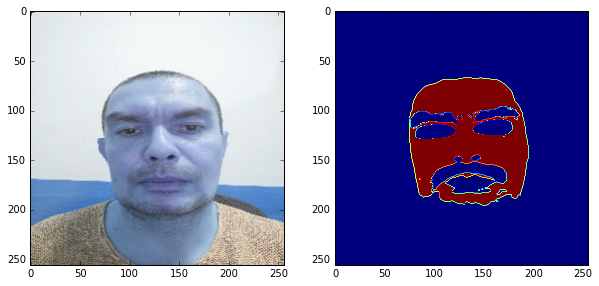

20
20


In [5]:
images =[]
images_grey = []
test_images = []
#import sorting directories
import os
from os import listdir
from os.path import isfile, join
last = 0
curr = 0
#sort images
print(image_dir)
for img in image_dir:
    if img.__contains__(".ipynb_checkpoints") or img.__contains__("flip"):
        continue
    img = cv2.imread(os.path.join(IMAGE_PATH,img))
    # img = cv2.resize(img, (256,256))/255.0
    img = cv2.resize(img, (256,256))
    
    images.append(img)
    images_grey.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
masks = []
skin_color = (212,198,169)
for mask in mask_dir:
    print(mask)
    mask = os.path.join(MASK_PATH,mask)
    file = io.loadmat(mask)
    img = file['M'].astype(np.uint8)

    #create binary mask for skin
    img = np.where(img != skin_color , (0,0,0), img)
    img = np.where(img == skin_color , (255,255,255), img)  
    img = np.asarray(img).astype(np.uint8)
    img = cv2.resize(img, (256,256))
    #convert to binary mask
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.0
    masks.append(img)



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[1])
ax[1].imshow(masks[1])
plt.show()
print(len(images))
print(len(masks))

In [7]:
train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)))

print("length: ", len(list(train)))
augmentations = []
for i in range(0,4):
    #map rotate_n_deg with argument degrees
    a = train.map(lambda x,y: rotate_n_deg(x,y, 10))

    augmentations.append(a)

train = train.concatenate(augmentations[0])
print("length: ", len(list(train)))


length:  20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
length:  40


In [169]:

#augment train dataset with rotations, flips, brightness, contrast, saturation, hue
#convert images to grayscale
# Create an instance of the ImageDataGenerator class
image_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.9,1.1],
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=0.2,
    validation_split=0.2,
    
)
mask_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,

    
)
# images = np.asarray(images)
#add 4th dim to images


data_aug = image_datagen.flow(np.asarray(images), batch_size=32, shuffle=True, seed=42, subset='training')
mask_aug = mask_datagen.flow(np.asarray(masks), batch_size=32, shuffle=True, seed=42, subset='training')

#add 4th dim to masks
# masks = np.reshape(masks, (len(masks),256,256,1))
# mask_aug = mask_datagen.flow(masks, batch_size=1, shuffle=True, seed=42)

# index = 0
# train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)))
# for m in mask_aug:
#     plt.imshow(m[0])
#     plt.show()
#     index += 1
#     if index > 200:
#         break

ValueError: setting an array element with a sequence.

In [170]:

   
image_aug = image_datagen.flow(np.asarray(images), batch_size=1, shuffle=True, seed=42, save_to_dir="/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/Face_Segmentation/augmented/images")

mask_aug = mask_datagen.flow(masks, batch_size=1, shuffle=True, seed=42, save_to_dir = "/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/Face_Segmentation/Augmented/masks")
index = 0
# for m in mask_aug:
#     plt.imshow(m[0])
#     plt.show()
#     index += 1
#     if index > 10:
#         break
# index = 0
# for i in image_aug:
#     plt.imshow(i[0])
#     plt.show()
#     index += 1
#     if index > 10:
#         break


ValueError: setting an array element with a sequence.

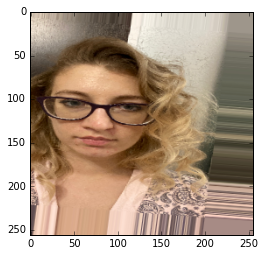

[[[228 213 193]
  [215 199 181]
  [217 204 183]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 [[227 211 192]
  [213 197 179]
  [219 206 185]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 [[225 210 191]
  [211 195 177]
  [221 208 187]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 ...

 [[ 94  75  77]
  [103  85  88]
  [106  86  85]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]

 [[ 95  76  79]
  [103  85  88]
  [111  90  88]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]

 [[ 97  78  81]
  [103  85  87]
  [115  93  90]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]]


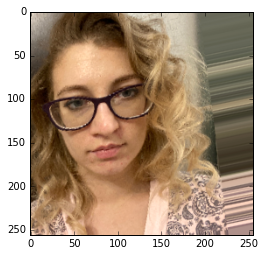

[[[228 213 198]
  [231 218 201]
  [220 207 190]
  ...
  [106 107  92]
  [107 108  93]
  [107 108  93]]

 [[228 212 198]
  [231 220 201]
  [218 206 189]
  ...
  [108 109  94]
  [108 109  94]
  [108 109  94]]

 [[216 202 190]
  [233 221 204]
  [231 220 202]
  ...
  [108 109  94]
  [107 108  93]
  [107 108  93]]

 ...

 [[248 211 188]
  [250 215 190]
  [246 211 186]
  ...
  [174 144 138]
  [174 144 138]
  [174 144 138]]

 [[254 220 196]
  [235 202 177]
  [255 218 196]
  ...
  [174 144 138]
  [174 144 138]
  [174 144 138]]

 [[255 224 199]
  [235 202 178]
  [249 213 189]
  ...
  [174 144 138]
  [174 144 138]
  [174 144 138]]]


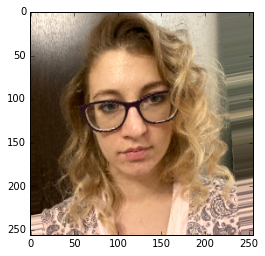

[[[219 200 186]
  [236 219 204]
  [248 232 215]
  ...
  [115 113  99]
  [115 113  99]
  [115 113  99]]

 [[218 201 185]
  [233 215 199]
  [255 238 221]
  ...
  [114 112  98]
  [114 112  98]
  [113 111  97]]

 [[223 205 189]
  [238 220 202]
  [250 234 217]
  ...
  [117 115 101]
  [118 116 102]
  [120 117 103]]

 ...

 [[255 242 221]
  [255 242 220]
  [255 241 218]
  ...
  [178 148 142]
  [178 148 142]
  [178 148 142]]

 [[255 240 213]
  [255 234 210]
  [255 229 205]
  ...
  [178 148 142]
  [178 148 142]
  [178 148 142]]

 [[247 208 192]
  [243 203 189]
  [242 203 189]
  ...
  [178 148 142]
  [178 148 142]
  [178 148 142]]]


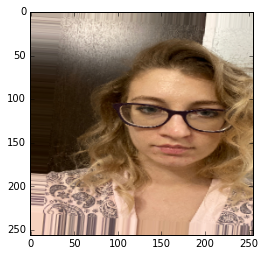

[[[191 174 159]
  [191 174 159]
  [191 174 159]
  ...
  [215 211 200]
  [217 213 202]
  [223 219 207]]

 [[191 174 159]
  [191 174 159]
  [191 174 159]
  ...
  [215 211 200]
  [217 213 202]
  [224 219 209]]

 [[191 174 159]
  [191 174 159]
  [191 174 159]
  ...
  [214 210 199]
  [218 214 203]
  [224 219 209]]

 ...

 [[246 209 190]
  [246 209 190]
  [246 209 190]
  ...
  [108  88  89]
  [101  80  80]
  [144 121 116]]

 [[246 209 190]
  [246 209 190]
  [246 209 190]
  ...
  [107  87  88]
  [105  85  84]
  [142 119 113]]

 [[246 209 190]
  [246 209 190]
  [246 209 190]
  ...
  [106  86  87]
  [109  88  87]
  [138 116 111]]]


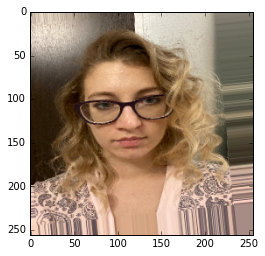

[[[193 174 158]
  [215 201 181]
  [188 169 155]
  ...
  [137 129 116]
  [137 129 116]
  [136 128 116]]

 [[186 166 152]
  [219 206 184]
  [189 170 157]
  ...
  [134 128 116]
  [134 128 116]
  [134 128 116]]

 [[180 158 146]
  [223 210 188]
  [191 172 157]
  ...
  [135 129 117]
  [135 129 117]
  [135 129 117]]

 ...

 [[246 210 190]
  [246 210 190]
  [246 210 190]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]

 [[246 210 190]
  [246 210 190]
  [246 210 190]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]

 [[246 210 190]
  [246 210 190]
  [246 210 190]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]]


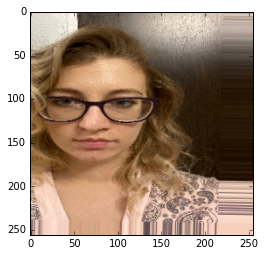

[[[228 224 213]
  [223 219 208]
  [218 214 203]
  ...
  [190 172 158]
  [190 172 158]
  [190 172 158]]

 [[226 222 211]
  [222 218 207]
  [214 210 199]
  ...
  [192 173 159]
  [192 173 159]
  [192 173 159]]

 [[215 211 200]
  [214 209 198]
  [213 208 197]
  ...
  [180 161 147]
  [180 161 147]
  [180 161 147]]

 ...

 [[188 167 157]
  [108  88  93]
  [128 100 101]
  ...
  [245 208 189]
  [245 208 189]
  [245 208 189]]

 [[186 166 155]
  [106  87  92]
  [128 101 101]
  ...
  [245 208 189]
  [245 208 189]
  [245 208 189]]

 [[184 163 152]
  [106  87  92]
  [129 101 101]
  ...
  [245 208 189]
  [245 208 189]
  [245 208 189]]]


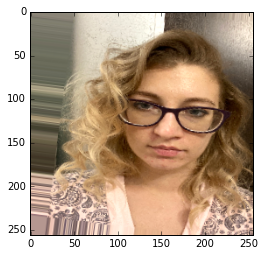

[[[140 133 120]
  [140 133 120]
  [140 133 120]
  ...
  [214 195 176]
  [230 212 192]
  [237 218 197]]

 [[139 132 119]
  [139 132 119]
  [139 132 119]
  ...
  [216 197 178]
  [231 213 193]
  [237 218 197]]

 [[140 134 121]
  [140 134 121]
  [140 134 121]
  ...
  [219 201 181]
  [232 214 193]
  [237 218 197]]

 ...

 [[181 151 144]
  [181 151 144]
  [181 151 144]
  ...
  [191 158 144]
  [196 162 145]
  [150 120 112]]

 [[181 151 144]
  [181 151 144]
  [181 151 144]
  ...
  [153 123 114]
  [139 108 102]
  [157 127 117]]

 [[181 151 144]
  [181 151 144]
  [181 151 144]
  ...
  [156 128 118]
  [126 100  95]
  [153 119 106]]]


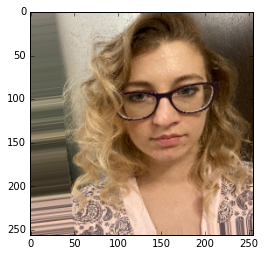

[[[139 131 120]
  [139 131 120]
  [139 131 120]
  ...
  [157 145 136]
  [165 154 143]
  [159 147 137]]

 [[141 136 121]
  [141 136 121]
  [143 136 121]
  ...
  [154 141 134]
  [169 156 147]
  [150 138 130]]

 [[144 136 120]
  [144 136 120]
  [144 136 120]
  ...
  [148 137 127]
  [174 162 152]
  [159 148 139]]

 ...

 [[139 114 108]
  [137 110 106]
  [133 107 105]
  ...
  [101  83  84]
  [134 111 108]
  [220 186 167]]

 [[130 106  97]
  [129 106  96]
  [129 106  95]
  ...
  [101  83  84]
  [124 101 101]
  [217 185 165]]

 [[167 140 123]
  [174 147 127]
  [180 152 133]
  ...
  [101  83  84]
  [113  93  95]
  [215 184 164]]]


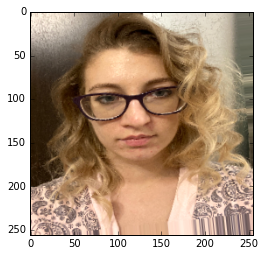

[[[253 234 219]
  [245 228 212]
  [255 241 224]
  ...
  [124 122 108]
  [125 123 109]
  [125 123 109]]

 [[255 246 228]
  [255 238 221]
  [255 241 223]
  ...
  [118 115 102]
  [116 114 100]
  [114 112  98]]

 [[255 245 226]
  [244 226 211]
  [247 230 214]
  ...
  [116 114 100]
  [118 116 102]
  [119 118 103]]

 ...

 [[193 157 149]
  [227 190 179]
  [255 230 213]
  ...
  [244 204 191]
  [234 196 179]
  [233 192 179]]

 [[194 160 155]
  [211 176 167]
  [255 226 208]
  ...
  [239 199 187]
  [237 197 181]
  [233 192 179]]

 [[209 175 163]
  [192 156 150]
  [255 216 204]
  ...
  [234 195 182]
  [238 198 183]
  [233 192 178]]]


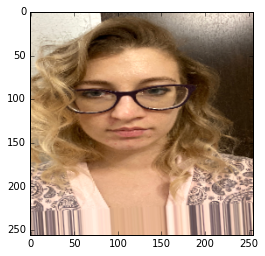

[[[233 230 216]
  [232 229 215]
  [234 230 217]
  ...
  [221 205 191]
  [203 186 175]
  [209 191 180]]

 [[234 230 217]
  [230 226 213]
  [234 230 217]
  ...
  [213 195 181]
  [205 185 175]
  [222 202 192]]

 [[231 227 214]
  [232 228 215]
  [237 232 219]
  ...
  [206 187 175]
  [207 189 175]
  [190 168 162]]

 ...

 [[140 116 122]
  [212 182 170]
  [164 135 124]
  ...
  [142 113 111]
  [255 224 199]
  [255 234 211]]

 [[134 111 118]
  [215 185 174]
  [167 138 128]
  ...
  [133 104 104]
  [255 219 196]
  [255 233 210]]

 [[128 105 114]
  [218 189 177]
  [170 142 131]
  ...
  [124  97  98]
  [249 212 190]
  [255 233 209]]]


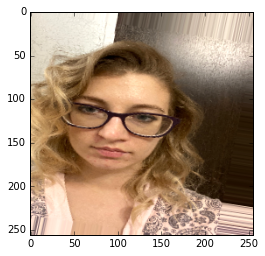

[[[224 215 202]
  [235 226 215]
  [237 230 217]
  ...
  [231 212 195]
  [224 205 191]
  [216 197 178]]

 [[225 216 202]
  [231 222 209]
  [231 222 209]
  ...
  [230 210 194]
  [222 203 188]
  [211 193 175]]

 [[226 218 204]
  [225 217 203]
  [226 218 204]
  ...
  [228 209 193]
  [220 202 185]
  [207 189 171]]

 ...

 [[255 223 207]
  [255 228 208]
  [186 156 149]
  ...
  [226 189 183]
  [247 208 200]
  [255 222 211]]

 [[255 223 207]
  [255 229 208]
  [168 138 133]
  ...
  [141 106 113]
  [139 105 112]
  [137 103 111]]

 [[255 224 207]
  [242 210 193]
  [167 138 135]
  ...
  [199 164 163]
  [182 146 148]
  [164 128 131]]]


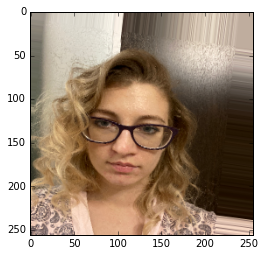

[[[157 149 138]
  [157 149 138]
  [157 149 138]
  ...
  [191 173 158]
  [191 173 158]
  [191 173 158]]

 [[157 149 138]
  [157 149 138]
  [157 149 138]
  ...
  [191 173 158]
  [191 173 158]
  [191 173 158]]

 [[157 149 138]
  [157 149 138]
  [157 149 138]
  ...
  [191 173 158]
  [191 173 158]
  [191 173 158]]

 ...

 [[142 118 115]
  [123 101 100]
  [150 128 126]
  ...
  [194 162 150]
  [183 152 141]
  [173 142 132]]

 [[113  93  94]
  [150 127 124]
  [148 124 121]
  ...
  [243 214 197]
  [238 209 193]
  [234 204 188]]

 [[109  89  91]
  [158 136 132]
  [133 109 106]
  ...
  [255 224 202]
  [255 225 203]
  [255 225 204]]]


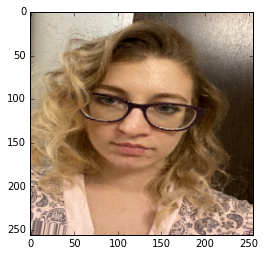

[[[119 116 103]
  [120 117 104]
  [126 122 109]
  ...
  [226 211 190]
  [222 207 186]
  [218 202 184]]

 [[120 117 103]
  [122 120 107]
  [128 125 112]
  ...
  [225 210 190]
  [222 207 186]
  [214 197 180]]

 [[119 116 102]
  [123 120 107]
  [129 126 114]
  ...
  [224 209 189]
  [222 207 188]
  [210 192 176]]

 ...

 [[241 209 192]
  [174 149 133]
  [120  99  91]
  ...
  [144 115 111]
  [142 113 111]
  [139 110 110]]

 [[241 208 191]
  [156 133 119]
  [120  99  93]
  ...
  [238 201 191]
  [224 190 180]
  [210 176 168]]

 [[240 207 191]
  [139 119 103]
  [120  98  95]
  ...
  [140 108 113]
  [156 123 126]
  [172 139 139]]]


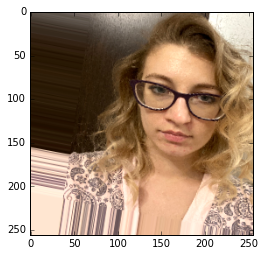

[[[101  92  84]
  [101  92  83]
  [101  92  83]
  ...
  [237 233 221]
  [247 243 231]
  [246 242 230]]

 [[ 92  82  74]
  [ 94  84  76]
  [ 96  86  78]
  ...
  [237 234 222]
  [247 243 230]
  [245 241 229]]

 [[ 96  86  76]
  [ 95  85  75]
  [ 94  84  75]
  ...
  [232 229 215]
  [241 236 223]
  [244 240 226]]

 ...

 [[255 230 209]
  [255 230 209]
  [255 230 209]
  ...
  [224 190 176]
  [179 154 149]
  [110  88  86]]

 [[255 230 209]
  [255 230 209]
  [255 230 209]
  ...
  [124 101 103]
  [141 118 110]
  [120  95  88]]

 [[255 230 209]
  [255 230 209]
  [255 230 209]
  ...
  [126 103 101]
  [199 165 154]
  [199 163 152]]]


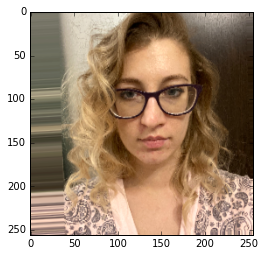

[[[130 123 111]
  [130 123 111]
  [130 123 112]
  ...
  [133 123 113]
  [134 125 113]
  [134 125 114]]

 [[134 126 116]
  [133 125 115]
  [132 123 114]
  ...
  [139 128 117]
  [138 128 117]
  [138 127 116]]

 [[117 113 101]
  [116 113 100]
  [115 112  99]
  ...
  [129 115 105]
  [128 115 105]
  [128 115 105]]

 ...

 [[141 116 108]
  [146 120 111]
  [150 123 114]
  ...
  [218 181 158]
  [255 224 200]
  [255 222 202]]

 [[197 164 149]
  [192 161 146]
  [188 156 143]
  ...
  [214 176 155]
  [255 224 200]
  [255 222 202]]

 [[126  99 101]
  [131 104 105]
  [136 109 111]
  ...
  [209 173 152]
  [255 224 200]
  [255 222 202]]]


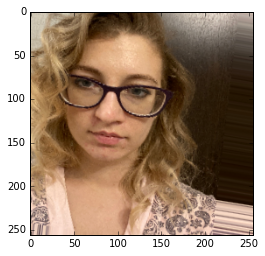

[[[198 191 172]
  [202 192 175]
  [207 199 180]
  ...
  [204 188 175]
  [206 190 177]
  [207 191 178]]

 [[198 190 172]
  [207 198 181]
  [209 201 182]
  ...
  [195 178 168]
  [195 178 168]
  [198 180 170]]

 [[200 192 173]
  [201 192 174]
  [209 201 181]
  ...
  [195 179 169]
  [195 179 169]
  [195 179 169]]

 ...

 [[223 190 171]
  [207 170 154]
  [209 175 163]
  ...
  [152 119 110]
  [161 128 116]
  [169 136 122]]

 [[219 184 167]
  [212 174 159]
  [193 162 153]
  ...
  [142 103 102]
  [123  84  87]
  [120  81  83]]

 [[213 180 162]
  [216 180 163]
  [179 150 142]
  ...
  [249 213 194]
  [236 200 182]
  [217 181 167]]]


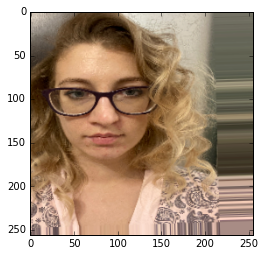

[[[217 203 188]
  [216 203 187]
  [226 215 199]
  ...
  [118 116 102]
  [118 116 102]
  [118 116 101]]

 [[221 210 193]
  [204 191 175]
  [207 196 181]
  ...
  [118 116 101]
  [118 116 101]
  [118 116 101]]

 [[220 207 192]
  [210 198 182]
  [200 188 172]
  ...
  [120 117 103]
  [120 117 103]
  [120 117 103]]

 ...

 [[242 205 189]
  [231 196 181]
  [138 112 114]
  ...
  [168 140 133]
  [168 140 133]
  [168 140 133]]

 [[242 205 189]
  [231 196 181]
  [141 115 116]
  ...
  [168 140 133]
  [168 140 133]
  [168 140 133]]

 [[242 205 189]
  [232 196 181]
  [144 118 120]
  ...
  [168 140 133]
  [168 140 133]
  [168 140 133]]]


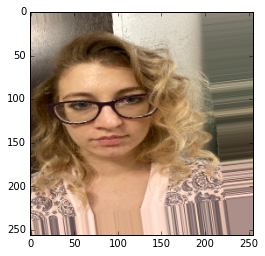

[[[195 178 159]
  [229 213 192]
  [182 163 147]
  ...
  [138 132 120]
  [138 132 120]
  [138 132 120]]

 [[198 181 162]
  [223 207 187]
  [190 171 154]
  ...
  [140 133 121]
  [140 133 121]
  [140 133 121]]

 [[201 184 164]
  [218 201 181]
  [197 179 161]
  ...
  [136 131 119]
  [136 131 119]
  [135 130 118]]

 ...

 [[159 131 119]
  [ 96  76  77]
  [214 183 168]
  ...
  [171 143 136]
  [171 143 136]
  [171 143 136]]

 [[166 137 124]
  [105  83  83]
  [196 167 155]
  ...
  [171 143 136]
  [171 143 136]
  [171 143 136]]

 [[173 144 129]
  [113  91  88]
  [180 152 142]
  ...
  [171 143 136]
  [171 143 136]
  [171 143 136]]]


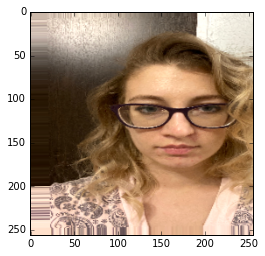

[[[204 185 170]
  [204 185 170]
  [204 185 170]
  ...
  [234 230 218]
  [238 233 222]
  [238 233 220]]

 [[204 185 170]
  [204 185 170]
  [204 185 170]
  ...
  [234 230 218]
  [238 233 222]
  [238 233 220]]

 [[204 185 170]
  [204 185 170]
  [204 185 170]
  ...
  [234 230 218]
  [238 233 222]
  [238 233 220]]

 ...

 [[255 224 203]
  [255 224 203]
  [255 224 203]
  ...
  [251 216 194]
  [251 217 196]
  [137 104 106]]

 [[255 224 203]
  [255 224 203]
  [255 224 203]
  ...
  [251 216 194]
  [253 219 197]
  [138 105 107]]

 [[255 224 203]
  [255 224 203]
  [255 224 203]
  ...
  [251 216 194]
  [253 219 197]
  [140 107 109]]]


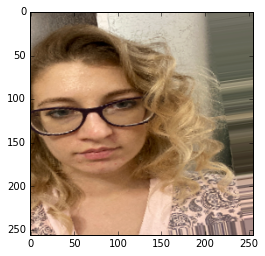

[[[147 136 122]
  [147 136 122]
  [148 136 122]
  ...
  [118 116 102]
  [118 116 102]
  [118 116 102]]

 [[146 136 121]
  [147 136 122]
  [148 136 122]
  ...
  [119 117 103]
  [119 117 103]
  [119 117 104]]

 [[142 131 116]
  [140 129 114]
  [146 135 120]
  ...
  [117 115 102]
  [116 114 102]
  [115 113 101]]

 ...

 [[219 185 165]
  [237 201 177]
  [199 165 148]
  ...
  [168 139 134]
  [168 139 134]
  [168 139 134]]

 [[208 172 160]
  [238 200 180]
  [231 194 175]
  ...
  [168 139 134]
  [168 139 134]
  [168 139 134]]

 [[241 205 185]
  [242 205 185]
  [236 199 179]
  ...
  [168 139 134]
  [168 139 134]
  [168 139 134]]]


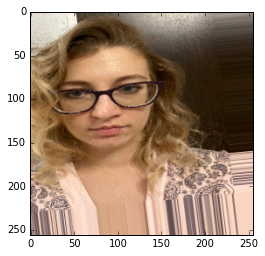

[[[231 227 216]
  [231 227 216]
  [224 220 208]
  ...
  [162 151 140]
  [164 153 142]
  [165 155 143]]

 [[228 224 213]
  [226 222 211]
  [221 217 205]
  ...
  [170 158 146]
  [170 158 146]
  [170 159 147]]

 [[220 216 204]
  [218 214 202]
  [220 216 204]
  ...
  [160 150 140]
  [159 149 139]
  [158 148 138]]

 ...

 [[213 186 167]
  [145 123 123]
  [139 119 117]
  ...
  [249 212 192]
  [249 212 192]
  [249 212 192]]

 [[216 188 168]
  [151 129 127]
  [139 119 117]
  ...
  [249 212 192]
  [249 212 192]
  [249 212 192]]

 [[208 181 162]
  [160 137 133]
  [140 120 118]
  ...
  [249 212 192]
  [249 212 192]
  [249 212 192]]]


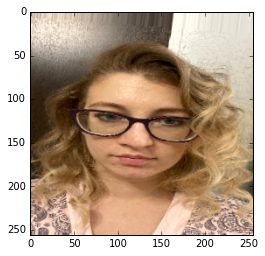

[[[207 188 171]
  [220 204 184]
  [236 220 202]
  ...
  [231 227 215]
  [230 225 214]
  [227 222 211]]

 [[207 189 171]
  [224 207 187]
  [230 213 195]
  ...
  [231 227 215]
  [229 224 213]
  [227 222 211]]

 [[208 190 172]
  [227 210 190]
  [224 206 189]
  ...
  [231 227 215]
  [229 224 213]
  [227 222 211]]

 ...

 [[114  94  96]
  [182 155 150]
  [161 131 127]
  ...
  [203 170 159]
  [174 143 131]
  [154 126 116]]

 [[122 102 103]
  [190 162 156]
  [156 125 121]
  ...
  [247 211 183]
  [247 210 183]
  [224 186 166]]

 [[130 109 109]
  [194 166 159]
  [150 119 116]
  ...
  [255 216 194]
  [255 216 193]
  [246 208 185]]]


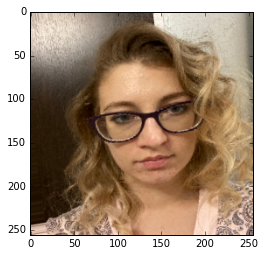

[[[193 174 163]
  [211 195 181]
  [201 183 169]
  ...
  [118 116 103]
  [118 116 103]
  [118 116 103]]

 [[202 184 170]
  [202 185 173]
  [209 192 178]
  ...
  [119 117 103]
  [119 117 103]
  [119 117 103]]

 [[210 193 178]
  [193 175 164]
  [218 201 186]
  ...
  [118 116 101]
  [118 116 101]
  [118 116 101]]

 ...

 [[213 184 168]
  [218 188 171]
  [222 191 174]
  ...
  [124 103  98]
  [109  90  88]
  [100  82  82]]

 [[238 205 186]
  [228 195 177]
  [215 183 167]
  ...
  [168 141 137]
  [138 114 110]
  [126 106 103]]

 [[164 134 123]
  [151 120 112]
  [164 134 123]
  ...
  [126 105 104]
  [131 107 106]
  [167 141 134]]]


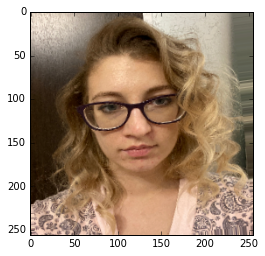

[[[231 216 198]
  [214 196 181]
  [208 192 176]
  ...
  [117 115 101]
  [117 115 101]
  [117 115 101]]

 [[235 218 202]
  [236 220 205]
  [214 197 182]
  ...
  [118 116 101]
  [118 116 102]
  [118 116 102]]

 [[217 202 185]
  [233 218 202]
  [219 202 189]
  ...
  [119 117 104]
  [118 116 103]
  [117 115 102]]

 ...

 [[127  97 107]
  [129 100 107]
  [131 102 108]
  ...
  [143 114 106]
  [130 102 100]
  [120  96  96]]

 [[145 115 112]
  [152 123 118]
  [163 134 127]
  ...
  [146 116 108]
  [129 102  98]
  [123  98 100]]

 [[231 196 187]
  [242 206 196]
  [233 196 189]
  ...
  [148 118 111]
  [129 101  96]
  [126 101 101]]]


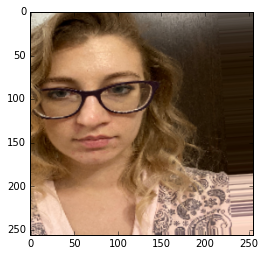

[[[220 216 203]
  [221 216 204]
  [223 218 206]
  ...
  [ 99  88  82]
  [ 99  88  82]
  [ 99  88  82]]

 [[225 219 207]
  [225 218 207]
  [223 216 205]
  ...
  [ 99  89  82]
  [ 99  89  82]
  [ 99  89  82]]

 [[220 214 202]
  [223 217 205]
  [222 216 204]
  ...
  [ 94  85  77]
  [ 93  84  77]
  [ 92  83  76]]

 ...

 [[148 122 113]
  [220 193 175]
  [230 202 184]
  ...
  [245 208 189]
  [245 208 189]
  [245 208 189]]

 [[148 122 114]
  [244 214 192]
  [225 198 184]
  ...
  [245 208 189]
  [245 208 189]
  [245 208 189]]

 [[169 142 134]
  [222 194 178]
  [228 201 185]
  ...
  [245 208 189]
  [245 208 189]
  [245 208 189]]]


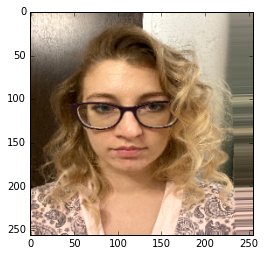

[[[233 216 198]
  [199 182 164]
  [253 235 218]
  ...
  [152 144 132]
  [152 144 132]
  [152 144 132]]

 [[228 211 194]
  [218 200 183]
  [233 214 197]
  ...
  [151 142 130]
  [151 142 130]
  [151 144 130]]

 [[227 208 192]
  [245 225 211]
  [226 209 192]
  ...
  [153 146 131]
  [153 146 131]
  [153 146 131]]

 ...

 [[255 231 210]
  [255 230 209]
  [255 226 206]
  ...
  [179 149 142]
  [179 149 142]
  [179 149 142]]

 [[255 232 211]
  [255 235 214]
  [255 226 206]
  ...
  [179 149 142]
  [179 149 142]
  [179 149 142]]

 [[216 177 169]
  [255 228 208]
  [255 226 206]
  ...
  [179 149 142]
  [179 149 142]
  [179 149 142]]]


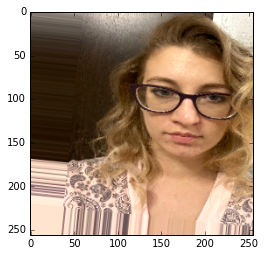

[[[137 127 116]
  [136 126 115]
  [135 125 114]
  ...
  [238 234 222]
  [242 237 225]
  [248 244 232]]

 [[141 129 119]
  [142 131 121]
  [145 133 123]
  ...
  [248 244 232]
  [238 234 222]
  [236 232 220]]

 [[131 118 109]
  [131 118 109]
  [131 118 109]
  ...
  [249 245 233]
  [243 238 226]
  [239 235 222]]

 ...

 [[255 228 208]
  [255 228 208]
  [255 228 208]
  ...
  [200 173 162]
  [114  92  93]
  [130 107 104]]

 [[255 228 208]
  [255 228 208]
  [255 228 208]
  ...
  [186 159 151]
  [113  91  92]
  [136 112 109]]

 [[255 228 208]
  [255 228 208]
  [255 228 208]
  ...
  [171 146 139]
  [112  90  90]
  [141 117 113]]]


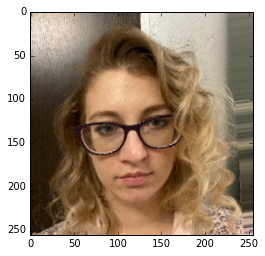

[[[188 169 154]
  [216 199 181]
  [207 187 171]
  ...
  [128 122 110]
  [128 122 110]
  [128 122 110]]

 [[189 170 155]
  [212 195 177]
  [211 192 175]
  ...
  [128 123 111]
  [128 123 111]
  [129 123 111]]

 [[190 171 156]
  [207 190 173]
  [215 196 179]
  ...
  [129 123 111]
  [129 123 111]
  [129 123 111]]

 ...

 [[ 30  13   3]
  [ 27  11   0]
  [ 46  28  17]
  ...
  [174 142 134]
  [179 148 138]
  [185 153 142]]

 [[ 29  12   2]
  [ 29  12   1]
  [ 72  54  40]
  ...
  [213 182 164]
  [217 186 167]
  [221 190 170]]

 [[ 29  12   1]
  [ 43  25  13]
  [119  98  85]
  ...
  [232 202 178]
  [225 194 171]
  [218 187 164]]]


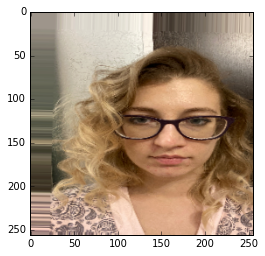

[[[158 149 139]
  [158 149 139]
  [158 149 139]
  ...
  [210 194 177]
  [220 208 186]
  [212 197 179]]

 [[158 149 139]
  [158 149 139]
  [158 149 139]
  ...
  [210 195 177]
  [220 207 186]
  [213 198 180]]

 [[158 149 139]
  [158 149 139]
  [158 149 139]
  ...
  [211 197 178]
  [220 207 186]
  [213 198 180]]

 ...

 [[167 139 132]
  [167 139 132]
  [167 139 132]
  ...
  [167 138 129]
  [179 148 139]
  [223 194 182]]

 [[167 139 132]
  [167 139 132]
  [167 139 132]
  ...
  [188 164 150]
  [171 146 135]
  [112  89  91]]

 [[167 139 132]
  [167 139 132]
  [167 139 132]
  ...
  [191 165 153]
  [213 185 170]
  [154 130 127]]]


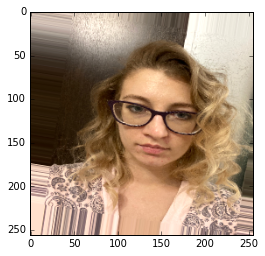

[[[217 199 179]
  [215 196 177]
  [213 194 175]
  ...
  [235 231 219]
  [234 229 217]
  [235 229 217]]

 [[179 161 153]
  [183 164 155]
  [189 171 159]
  ...
  [234 231 218]
  [234 229 217]
  [235 229 218]]

 [[185 164 155]
  [176 157 147]
  [174 154 145]
  ...
  [234 231 218]
  [234 229 217]
  [236 228 217]]

 ...

 [[255 224 204]
  [255 224 204]
  [255 224 204]
  ...
  [255 226 204]
  [254 211 191]
  [230 190 172]]

 [[255 224 204]
  [255 224 204]
  [255 224 204]
  ...
  [255 225 214]
  [255 225 215]
  [255 225 213]]

 [[255 224 204]
  [255 224 204]
  [255 224 204]
  ...
  [236 194 183]
  [255 214 198]
  [255 229 209]]]


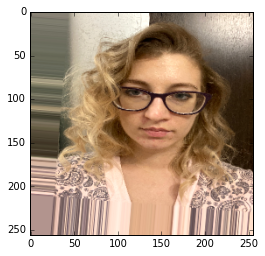

[[[138 133 120]
  [138 133 120]
  [138 133 120]
  ...
  [235 220 198]
  [200 178 163]
  [246 231 214]]

 [[137 130 117]
  [137 130 117]
  [137 130 117]
  ...
  [238 224 201]
  [194 171 158]
  [251 237 219]]

 [[138 131 118]
  [138 131 118]
  [138 131 118]
  ...
  [241 229 205]
  [189 164 153]
  [245 230 213]]

 ...

 [[178 148 142]
  [178 148 142]
  [178 148 142]
  ...
  [255 223 203]
  [255 223 203]
  [255 223 203]]

 [[178 148 142]
  [178 148 142]
  [178 148 142]
  ...
  [255 223 203]
  [255 223 203]
  [255 223 203]]

 [[178 148 142]
  [178 148 142]
  [178 148 142]
  ...
  [255 223 203]
  [255 223 203]
  [255 223 203]]]


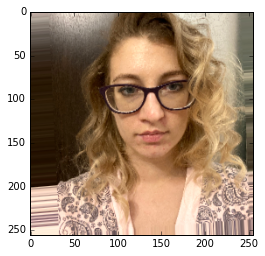

[[[209 194 184]
  [208 193 183]
  [207 193 183]
  ...
  [122 121 107]
  [122 121 107]
  [121 120 106]]

 [[201 188 178]
  [201 188 177]
  [201 186 177]
  ...
  [114 112  98]
  [113 111  97]
  [112 110  96]]

 [[200 181 172]
  [198 180 171]
  [198 180 171]
  ...
  [116 114 100]
  [118 115 100]
  [118 115 101]]

 ...

 [[255 242 220]
  [255 243 220]
  [255 243 220]
  ...
  [182 151 145]
  [182 151 145]
  [182 151 145]]

 [[255 235 216]
  [255 235 216]
  [255 233 215]
  ...
  [182 151 145]
  [182 151 145]
  [182 151 145]]

 [[255 239 218]
  [255 239 218]
  [255 240 218]
  ...
  [182 151 145]
  [182 151 145]
  [182 151 145]]]


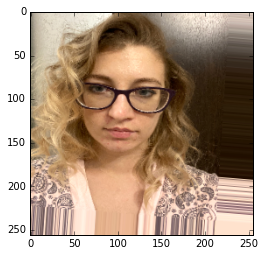

[[[131 129 114]
  [139 136 122]
  [148 145 129]
  ...
  [190 172 161]
  [194 175 163]
  [197 178 166]]

 [[131 128 114]
  [141 136 123]
  [151 145 130]
  ...
  [176 156 147]
  [176 157 148]
  [177 158 149]]

 [[131 129 115]
  [141 136 123]
  [150 146 130]
  ...
  [211 192 178]
  [208 189 175]
  [203 185 172]]

 ...

 [[147 116 109]
  [215 186 169]
  [114  92 103]
  ...
  [255 226 205]
  [255 226 205]
  [255 226 205]]

 [[154 123 115]
  [206 178 163]
  [114  91 103]
  ...
  [255 226 205]
  [255 226 205]
  [255 226 205]]

 [[161 130 120]
  [198 170 157]
  [114  91 103]
  ...
  [255 226 205]
  [255 226 205]
  [255 226 205]]]


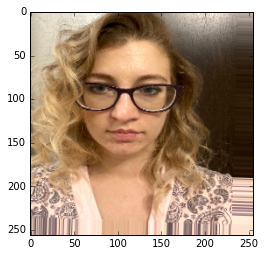

[[[195 186 168]
  [204 193 177]
  [204 194 178]
  ...
  [207 192 182]
  [207 192 182]
  [208 192 183]]

 [[197 188 168]
  [203 193 177]
  [202 192 176]
  ...
  [199 186 176]
  [199 186 176]
  [199 186 176]]

 [[195 187 167]
  [197 189 170]
  [202 192 176]
  ...
  [196 178 169]
  [196 178 169]
  [197 179 170]]

 ...

 [[147 120 116]
  [142 116 114]
  [253 220 194]
  ...
  [255 226 205]
  [255 226 205]
  [255 226 205]]

 [[147 120 116]
  [146 120 116]
  [249 216 191]
  ...
  [255 226 205]
  [255 226 205]
  [255 226 205]]

 [[147 120 116]
  [150 123 120]
  [246 213 189]
  ...
  [255 226 205]
  [255 226 205]
  [255 226 205]]]


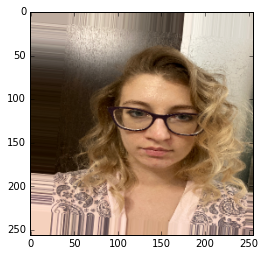

[[[190 172 159]
  [190 172 159]
  [190 172 159]
  ...
  [214 206 194]
  [213 205 193]
  [213 205 193]]

 [[190 172 159]
  [190 172 159]
  [190 172 159]
  ...
  [213 205 193]
  [213 205 193]
  [213 205 193]]

 [[190 172 159]
  [190 172 159]
  [190 172 159]
  ...
  [213 205 193]
  [213 205 193]
  [213 204 192]]

 ...

 [[245 209 189]
  [245 209 189]
  [245 209 189]
  ...
  [166 138 132]
  [166 138 132]
  [166 138 132]]

 [[245 209 189]
  [245 209 189]
  [245 209 189]
  ...
  [166 138 132]
  [166 138 132]
  [166 138 132]]

 [[245 209 189]
  [245 209 189]
  [245 209 189]
  ...
  [166 138 132]
  [166 138 132]
  [166 138 132]]]


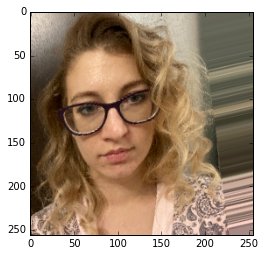

[[[226 210 193]
  [226 210 193]
  [227 211 195]
  ...
  [102 101  87]
  [102 101  87]
  [101 101  86]]

 [[223 206 191]
  [226 210 194]
  [238 224 207]
  ...
  [100 101  85]
  [100 101  85]
  [ 99 100  85]]

 [[222 205 190]
  [228 214 198]
  [240 228 211]
  ...
  [ 98  99  85]
  [ 99  99  85]
  [ 99  99  85]]

 ...

 [[219 184 167]
  [217 180 163]
  [204 169 148]
  ...
  [167 138 132]
  [167 138 132]
  [167 138 132]]

 [[221 181 166]
  [203 167 152]
  [177 147 132]
  ...
  [167 138 132]
  [167 138 132]
  [167 138 132]]

 [[129 106  96]
  [101  80  74]
  [ 99  80  76]
  ...
  [167 138 132]
  [167 138 132]
  [167 138 132]]]


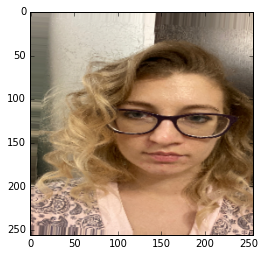

[[[158 150 139]
  [158 150 139]
  [158 150 139]
  ...
  [208 192 172]
  [193 177 158]
  [212 195 175]]

 [[158 150 139]
  [158 150 139]
  [158 150 139]
  ...
  [205 188 169]
  [196 179 160]
  [213 196 176]]

 [[158 150 139]
  [158 150 139]
  [158 150 139]
  ...
  [202 185 166]
  [197 180 161]
  [214 197 177]]

 ...

 [[108  84  87]
  [131 105 105]
  [129 101  96]
  ...
  [148 123 119]
  [161 132 127]
  [211 178 165]]

 [[110  87  89]
  [131 105 104]
  [129 101  95]
  ...
  [166 136 132]
  [176 150 140]
  [184 158 147]]

 [[113  89  91]
  [131 105 103]
  [130 102  95]
  ...
  [205 174 161]
  [126 102 102]
  [101  83  87]]]


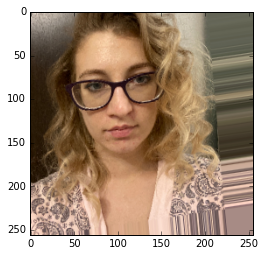

[[[213 202 188]
  [196 184 171]
  [214 203 190]
  ...
  [100 101  87]
  [100 101  87]
  [100 101  87]]

 [[212 202 186]
  [201 188 176]
  [202 188 176]
  ...
  [101 102  88]
  [101 102  88]
  [102 103  89]]

 [[220 209 196]
  [209 198 187]
  [185 169 160]
  ...
  [103 104  90]
  [103 104  90]
  [103 104  90]]

 ...

 [[188 153 149]
  [244 208 195]
  [252 221 206]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]

 [[146 111 112]
  [251 217 201]
  [246 211 194]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]

 [[149 117 116]
  [248 213 196]
  [248 212 197]
  ...
  [167 139 133]
  [167 139 133]
  [167 139 133]]]


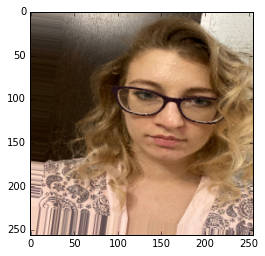

[[[148 137 128]
  [148 138 129]
  [149 139 130]
  ...
  [223 220 208]
  [222 217 206]
  [221 217 206]]

 [[146 135 126]
  [146 136 126]
  [146 136 126]
  ...
  [223 220 208]
  [223 220 208]
  [222 218 207]]

 [[124 116 105]
  [126 118 107]
  [130 120 110]
  ...
  [225 222 210]
  [222 219 207]
  [222 218 207]]

 ...

 [[246 208 190]
  [246 208 190]
  [246 208 190]
  ...
  [163 133 122]
  [193 166 154]
  [109  87  89]]

 [[246 208 190]
  [246 208 190]
  [246 208 190]
  ...
  [172 142 129]
  [192 164 151]
  [123 102 101]]

 [[246 208 190]
  [246 208 190]
  [246 208 190]
  ...
  [192 162 145]
  [189 161 147]
  [129 104 103]]]


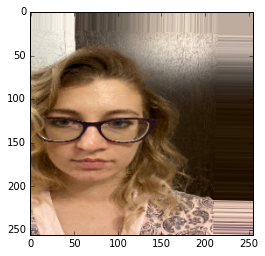

[[[214 210 199]
  [217 213 202]
  [224 221 209]
  ...
  [190 172 158]
  [190 172 158]
  [190 172 158]]

 [[214 210 199]
  [217 213 202]
  [225 222 210]
  ...
  [190 172 158]
  [190 172 158]
  [190 172 158]]

 [[214 210 199]
  [217 213 202]
  [225 222 210]
  ...
  [190 172 158]
  [190 172 158]
  [190 172 158]]

 ...

 [[216 186 171]
  [190 161 148]
  [201 175 162]
  ...
  [177 145 137]
  [177 145 137]
  [177 146 137]]

 [[212 185 171]
  [224 196 179]
  [166 143 137]
  ...
  [157 122 122]
  [158 123 123]
  [159 124 124]]

 [[137 113 114]
  [186 160 150]
  [186 161 151]
  ...
  [185 151 147]
  [183 149 146]
  [180 147 144]]]


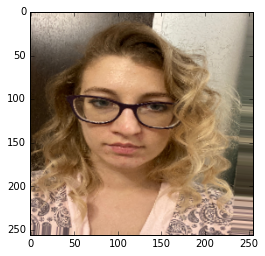

[[[246 233 219]
  [221 204 193]
  [245 233 217]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 [[245 232 217]
  [236 220 206]
  [240 227 210]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 [[226 210 198]
  [206 189 179]
  [239 228 214]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 ...

 [[229 197 177]
  [235 193 177]
  [211 181 161]
  ...
  [120  97  92]
  [113  92  87]
  [110  89  85]]

 [[229 196 177]
  [233 192 176]
  [209 180 159]
  ...
  [188 158 142]
  [194 163 146]
  [193 162 145]]

 [[230 196 177]
  [231 191 174]
  [200 172 153]
  ...
  [124  98 100]
  [116  91  94]
  [121  95  97]]]


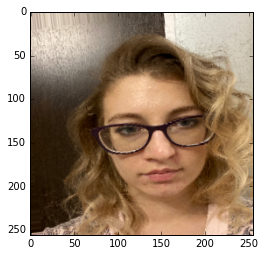

[[[218 202 183]
  [209 192 177]
  [188 170 159]
  ...
  [207 200 184]
  [207 198 184]
  [208 199 185]]

 [[214 198 179]
  [216 199 183]
  [182 162 153]
  ...
  [210 201 186]
  [213 204 189]
  [211 203 188]]

 [[211 195 176]
  [223 207 190]
  [175 155 147]
  ...
  [211 202 187]
  [213 204 189]
  [212 203 188]]

 ...

 [[ 27   7   0]
  [ 27   7   0]
  [ 47  27  17]
  ...
  [240 207 188]
  [239 205 186]
  [239 205 187]]

 [[176 152 129]
  [197 171 147]
  [218 191 165]
  ...
  [242 207 190]
  [240 205 186]
  [239 204 185]]

 [[167 140 123]
  [158 130 116]
  [150 120 108]
  ...
  [210 180 168]
  [244 211 194]
  [251 220 201]]]


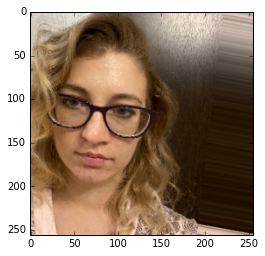

[[[205 198 182]
  [206 200 183]
  [211 204 188]
  ...
  [191 174 159]
  [191 174 159]
  [191 174 159]]

 [[207 200 183]
  [206 200 182]
  [208 202 185]
  ...
  [191 174 159]
  [191 174 159]
  [191 174 159]]

 [[212 205 188]
  [211 204 187]
  [215 206 190]
  ...
  [191 174 159]
  [191 174 159]
  [191 174 159]]

 ...

 [[187 160 152]
  [190 162 153]
  [158 129 125]
  ...
  [ 28   9   0]
  [ 30  10   0]
  [ 30  11   0]]

 [[191 164 154]
  [182 154 145]
  [186 158 147]
  ...
  [ 99  77  62]
  [ 70  48  36]
  [ 41  20  11]]

 [[162 138 130]
  [129 103 102]
  [216 190 176]
  ...
  [207 181 157]
  [221 193 168]
  [200 174 148]]]


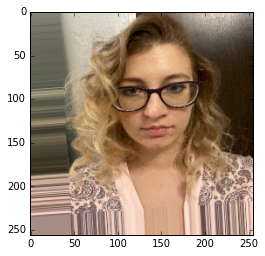

[[[140 131 120]
  [140 131 120]
  [140 132 121]
  ...
  [172 154 145]
  [172 154 145]
  [172 154 145]]

 [[140 132 121]
  [140 132 121]
  [140 132 121]
  ...
  [168 151 143]
  [167 151 142]
  [167 151 142]]

 [[140 133 121]
  [140 134 121]
  [141 134 121]
  ...
  [160 145 135]
  [158 144 135]
  [157 143 134]]

 ...

 [[167 140 133]
  [167 140 133]
  [167 140 133]
  ...
  [246 209 190]
  [243 207 188]
  [251 215 196]]

 [[167 140 133]
  [167 140 133]
  [167 140 133]
  ...
  [246 209 190]
  [243 207 188]
  [251 215 195]]

 [[167 140 133]
  [167 140 133]
  [167 140 133]
  ...
  [247 210 190]
  [243 207 188]
  [251 215 195]]]


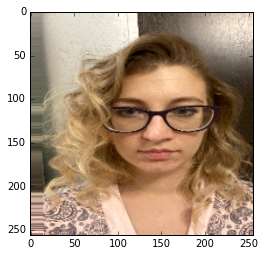

[[[164 155 144]
  [164 155 144]
  [164 155 144]
  ...
  [208 189 174]
  [226 214 192]
  [229 211 195]]

 [[164 155 144]
  [164 155 144]
  [164 155 144]
  ...
  [208 189 174]
  [226 214 192]
  [229 211 195]]

 [[164 155 144]
  [164 155 144]
  [164 155 144]
  ...
  [208 189 174]
  [226 214 192]
  [228 211 195]]

 ...

 [[255 221 203]
  [255 221 202]
  [255 221 202]
  ...
  [131 105 101]
  [141 116 112]
  [149 123 120]]

 [[148 114 120]
  [149 114 120]
  [149 114 120]
  ...
  [175 149 139]
  [162 134 123]
  [202 173 151]]

 [[152 122 118]
  [152 122 118]
  [152 122 118]
  ...
  [175 149 140]
  [162 134 123]
  [201 173 151]]]


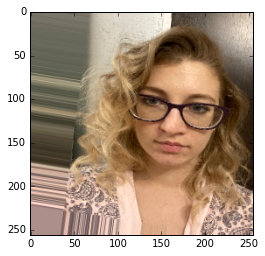

[[[122 120 105]
  [122 120 104]
  [122 120 104]
  ...
  [223 205 187]
  [224 206 189]
  [206 191 171]]

 [[121 119 105]
  [122 120 106]
  [123 121 107]
  ...
  [223 205 188]
  [220 204 186]
  [206 191 171]]

 [[119 117 103]
  [119 117 103]
  [118 116 102]
  ...
  [223 205 188]
  [218 202 183]
  [206 190 171]]

 ...

 [[172 143 137]
  [172 143 137]
  [172 143 137]
  ...
  [202 169 159]
  [171 137 130]
  [193 157 150]]

 [[172 143 137]
  [172 143 137]
  [172 143 137]
  ...
  [188 157 150]
  [221 187 168]
  [212 174 163]]

 [[172 143 137]
  [172 143 137]
  [172 143 137]
  ...
  [228 190 168]
  [250 213 192]
  [255 223 202]]]


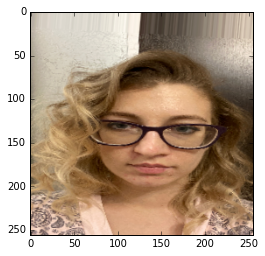

[[[163 153 142]
  [165 157 146]
  [178 170 158]
  ...
  [201 185 167]
  [201 182 167]
  [218 206 184]]

 [[164 153 143]
  [165 158 146]
  [179 171 160]
  ...
  [201 185 167]
  [202 182 168]
  [220 208 186]]

 [[164 153 143]
  [165 158 146]
  [180 172 162]
  ...
  [201 185 167]
  [203 184 169]
  [222 211 188]]

 ...

 [[161 133 120]
  [126 103 102]
  [107  86  90]
  ...
  [121  98  88]
  [209 176 161]
  [215 179 163]]

 [[208 178 161]
  [149 122 114]
  [157 133 122]
  ...
  [219 186 169]
  [244 208 193]
  [234 197 180]]

 [[134 112 110]
  [133 107 106]
  [197 168 150]
  ...
  [239 206 187]
  [244 208 190]
  [235 198 181]]]


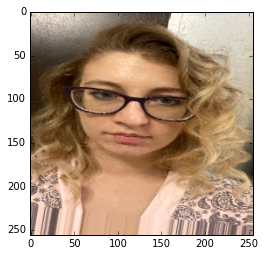

[[[245 231 216]
  [245 230 217]
  [236 223 209]
  ...
  [227 222 212]
  [225 220 210]
  [223 219 208]]

 [[242 229 215]
  [234 219 206]
  [232 218 205]
  ...
  [226 222 211]
  [224 220 209]
  [224 220 209]]

 [[237 223 210]
  [228 213 200]
  [235 225 211]
  ...
  [226 221 211]
  [224 219 209]
  [226 222 211]]

 ...

 [[164 139 137]
  [124 101 102]
  [123  99 103]
  ...
  [171 142 136]
  [171 142 136]
  [171 142 136]]

 [[163 139 137]
  [116  94  96]
  [127 102 107]
  ...
  [171 142 136]
  [171 142 136]
  [171 142 136]]

 [[155 132 130]
  [110  89  91]
  [130 104 110]
  ...
  [171 142 136]
  [171 142 136]
  [171 142 136]]]


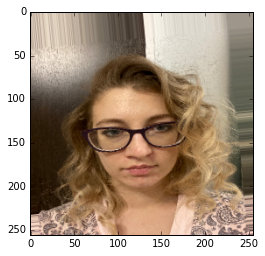

[[[197 179 163]
  [217 201 182]
  [201 182 169]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 [[196 178 163]
  [214 197 178]
  [207 189 175]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 [[195 178 162]
  [212 194 175]
  [213 196 181]
  ...
  [158 150 139]
  [158 150 139]
  [158 150 139]]

 ...

 [[214 182 167]
  [223 192 175]
  [233 202 184]
  ...
  [253 212 197]
  [253 212 197]
  [253 212 196]]

 [[231 198 180]
  [227 193 176]
  [224 189 173]
  ...
  [193 156 151]
  [182 145 143]
  [170 134 135]]

 [[236 205 183]
  [238 209 185]
  [241 212 187]
  ...
  [145 113 114]
  [145 114 113]
  [145 115 113]]]


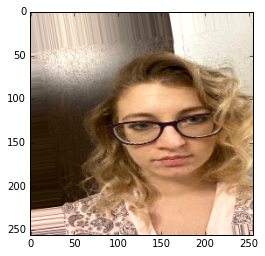

[[[214 194 179]
  [216 196 181]
  [220 201 185]
  ...
  [232 224 212]
  [240 231 219]
  [230 222 208]]

 [[213 193 178]
  [217 197 182]
  [217 197 182]
  ...
  [232 224 212]
  [239 230 218]
  [232 224 211]]

 [[211 191 176]
  [218 199 183]
  [214 194 179]
  ...
  [232 224 212]
  [238 229 217]
  [235 226 214]]

 ...

 [[172 138 142]
  [155 122 130]
  [139 107 117]
  ...
  [255 220 197]
  [249 215 194]
  [130  96 100]]

 [[156 124 122]
  [158 126 122]
  [172 139 134]
  ...
  [253 218 195]
  [255 224 201]
  [143 109 110]]

 [[255 226 215]
  [252 214 204]
  [235 197 191]
  ...
  [248 212 190]
  [255 224 201]
  [162 129 126]]]


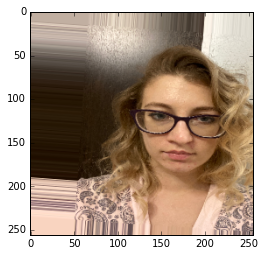

[[[193 175 161]
  [193 175 161]
  [193 175 161]
  ...
  [223 219 208]
  [217 213 202]
  [220 215 205]]

 [[193 175 161]
  [193 175 161]
  [193 175 161]
  ...
  [223 219 208]
  [216 212 201]
  [220 216 205]]

 [[193 175 161]
  [193 175 161]
  [193 175 161]
  ...
  [222 218 207]
  [216 212 201]
  [221 216 206]]

 ...

 [[249 212 192]
  [249 212 192]
  [249 212 192]
  ...
  [207 178 167]
  [105  84  96]
  [139 116 118]]

 [[249 212 192]
  [249 212 192]
  [249 212 192]
  ...
  [198 171 162]
  [105  84  96]
  [148 124 123]]

 [[249 212 192]
  [249 212 192]
  [249 212 192]
  ...
  [190 164 156]
  [106  84  96]
  [156 132 129]]]


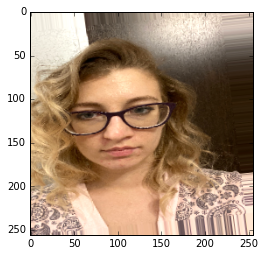

[[[244 240 228]
  [246 242 230]
  [243 239 227]
  ...
  [235 216 200]
  [239 220 204]
  [238 219 204]]

 [[244 240 228]
  [246 242 230]
  [244 240 227]
  ...
  [237 217 200]
  [238 218 201]
  [240 220 203]]

 [[243 240 227]
  [246 242 230]
  [244 240 228]
  ...
  [244 224 207]
  [238 217 201]
  [232 210 196]]

 ...

 [[160 133 129]
  [159 132 128]
  [154 128 125]
  ...
  [255 230 209]
  [255 230 209]
  [255 230 209]]

 [[129 105 106]
  [129 106 106]
  [129 104 107]
  ...
  [255 230 209]
  [255 230 209]
  [255 230 209]]

 [[167 140 133]
  [136 109 108]
  [195 170 163]
  ...
  [255 230 209]
  [255 230 209]
  [255 230 209]]]


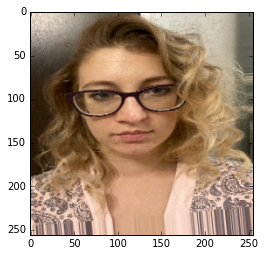

[[[246 232 211]
  [241 226 211]
  [246 235 217]
  ...
  [118 116 101]
  [118 116 102]
  [118 116 102]]

 [[246 231 213]
  [234 216 201]
  [249 236 220]
  ...
  [119 117 104]
  [118 116 103]
  [118 116 103]]

 [[248 234 217]
  [234 219 203]
  [245 234 217]
  ...
  [114 112  99]
  [115 113 100]
  [115 113 100]]

 ...

 [[224 188 177]
  [255 219 203]
  [253 222 208]
  ...
  [169 141 132]
  [221 184 172]
  [224 187 172]]

 [[219 183 174]
  [255 219 202]
  [253 222 209]
  ...
  [162 134 126]
  [217 181 169]
  [225 188 174]]

 [[215 179 169]
  [255 218 201]
  [253 223 210]
  ...
  [155 128 121]
  [213 177 166]
  [227 189 175]]]


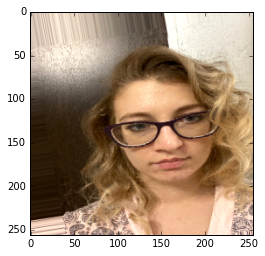

[[[221 203 186]
  [218 199 182]
  [200 179 165]
  ...
  [214 205 186]
  [208 200 182]
  [203 192 181]]

 [[218 200 182]
  [224 204 188]
  [201 180 165]
  ...
  [215 206 186]
  [210 201 182]
  [204 193 182]]

 [[216 198 180]
  [228 210 192]
  [202 181 166]
  ...
  [216 207 188]
  [211 202 182]
  [205 194 182]]

 ...

 [[191 158 146]
  [176 144 134]
  [162 130 122]
  ...
  [142 108 109]
  [236 199 182]
  [255 231 211]]

 [[217 183 170]
  [230 196 181]
  [243 208 192]
  ...
  [164 130 128]
  [213 177 165]
  [255 229 208]]

 [[255 236 217]
  [255 241 223]
  [255 247 226]
  ...
  [187 153 145]
  [190 155 147]
  [255 227 206]]]


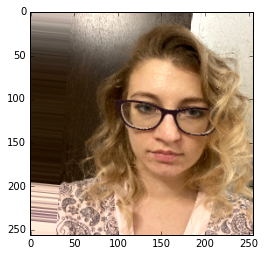

[[[219 201 188]
  [218 200 187]
  [217 200 187]
  ...
  [247 242 231]
  [241 237 225]
  [239 234 223]]

 [[209 190 179]
  [211 192 180]
  [213 194 182]
  ...
  [247 242 231]
  [241 237 225]
  [239 234 223]]

 [[206 188 179]
  [205 187 178]
  [204 186 177]
  ...
  [244 240 229]
  [241 237 225]
  [239 234 223]]

 ...

 [[255 227 206]
  [255 227 206]
  [255 227 206]
  ...
  [188 161 146]
  [138 111 109]
  [129 104 106]]

 [[255 227 206]
  [255 227 206]
  [255 227 206]
  ...
  [131 107 108]
  [169 142 136]
  [243 211 193]]

 [[255 227 206]
  [255 227 206]
  [255 227 206]
  ...
  [255 241 217]
  [255 230 205]
  [255 234 211]]]


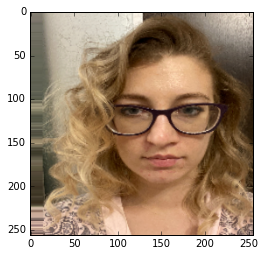

[[[136 129 116]
  [136 129 116]
  [136 129 116]
  ...
  [245 234 219]
  [241 227 212]
  [243 233 216]]

 [[135 129 116]
  [135 129 116]
  [135 129 116]
  ...
  [236 222 206]
  [230 216 200]
  [239 227 212]]

 [[136 130 117]
  [136 130 117]
  [136 130 117]
  ...
  [228 215 198]
  [225 212 195]
  [239 228 212]]

 ...

 [[115  92  87]
  [114  92  87]
  [114  91  86]
  ...
  [139 116 112]
  [134 112 112]
  [137 115 115]]

 [[115  90  85]
  [115  90  85]
  [115  90  85]
  ...
  [165 140 134]
  [151 129 124]
  [123 104 104]]

 [[201 167 149]
  [201 167 150]
  [202 168 151]
  ...
  [152 126 120]
  [139 113 108]
  [123 100  96]]]


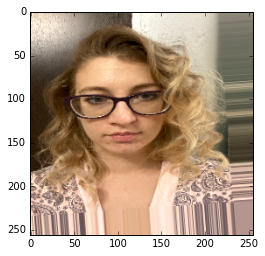

[[[242 226 203]
  [249 234 214]
  [252 237 218]
  ...
  [147 139 125]
  [147 139 125]
  [147 139 125]]

 [[241 226 203]
  [248 233 213]
  [252 237 218]
  ...
  [144 138 125]
  [144 138 125]
  [144 138 125]]

 [[241 225 202]
  [248 233 212]
  [252 239 218]
  ...
  [146 140 126]
  [145 139 126]
  [145 139 126]]

 ...

 [[248 210 196]
  [255 237 221]
  [255 239 220]
  ...
  [180 150 143]
  [180 150 143]
  [180 150 143]]

 [[244 205 192]
  [255 236 220]
  [255 239 221]
  ...
  [180 150 143]
  [180 150 143]
  [180 150 143]]

 [[240 201 189]
  [255 236 219]
  [255 239 221]
  ...
  [180 150 143]
  [180 150 143]
  [180 150 143]]]


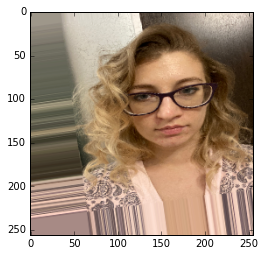

[[[158 151 138]
  [158 151 138]
  [158 151 138]
  ...
  [191 176 161]
  [206 190 178]
  [199 183 171]]

 [[158 151 138]
  [158 151 138]
  [158 151 138]
  ...
  [206 190 177]
  [204 188 174]
  [194 177 165]]

 [[158 151 138]
  [158 151 138]
  [158 151 138]
  ...
  [202 186 174]
  [198 181 169]
  [193 176 163]]

 ...

 [[167 138 133]
  [167 138 133]
  [167 138 133]
  ...
  [182 151 143]
  [172 148 137]
  [160 132 125]]

 [[167 138 133]
  [167 138 133]
  [167 138 133]
  ...
  [204 169 159]
  [154 131 123]
  [174 146 136]]

 [[167 138 133]
  [167 138 133]
  [167 138 133]
  ...
  [225 188 175]
  [137 113 109]
  [184 160 147]]]


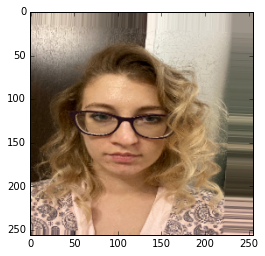

[[[212 194 179]
  [190 175 160]
  [197 180 165]
  ...
  [158 149 138]
  [158 149 138]
  [158 149 138]]

 [[213 194 179]
  [189 174 159]
  [198 180 165]
  ...
  [158 149 138]
  [158 149 138]
  [158 149 138]]

 [[213 195 179]
  [187 172 157]
  [199 181 166]
  ...
  [158 149 138]
  [158 149 138]
  [158 149 138]]

 ...

 [[151 119 110]
  [182 151 135]
  [122  99  94]
  ...
  [158 129 122]
  [163 133 126]
  [168 138 130]]

 [[156 123 113]
  [179 149 133]
  [119  97  92]
  ...
  [214 176 161]
  [208 172 157]
  [201 167 151]]

 [[160 126 115]
  [177 146 132]
  [117  94  90]
  ...
  [252 211 197]
  [252 211 197]
  [252 211 197]]]


In [12]:
images =[]
images_grey = []
test_images = []
#import sorting directories
import os
from os import listdir
from os.path import isfile, join
last = 0
curr = 0
#sort images
index = 0
for img in AUGMENTED_IMAGES_DIR:
    img = os.path.join(AUGMENTED_IMAGES_PATH,img)
    if img.__contains__(".ipynb_checkpoints") or img.__contains__("flip"):
        continue
    img = cv2.imread(img)
    # img = np.asarray(img).astype(np.float32)
    # img = cv2.resize(img, (256,256))/255.0
    # img = cv2.resize(img, (1,256,256,3))
    #show image

    if index%1000 == 0:
        plt.imshow(img)
        plt.show()
    print(img)
    
    images.append(img)
    # images_grey.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

    
masks = []
index = 0

for img in AUGMENTED_MASKS_DIR:
    img = os.path.join(AUGMENTED_MASKS_PATH,img)
    if img.__contains__(".ipynb_checkpoints") or img.__contains__("flip"):
        continue
    # img = cv2.imread(img)
    # img = np.asarray(img).astype(np.float32)
    # img = np.asarray(img).astype(np.float32)
    # img = cv2.resize(img, (256,256))/255.0
    # img = cv2.resize(img, (1,256,256,3))
    #show mask
    if index%1000 == 0:
        plt.imshow(img)
        plt.show()
    print(img)
    masks.append(img)




print(len(images))
print(len(masks))
#take matching images and masks and put them in a dataset
# train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)))

# print("length: ", len(list(train)))
# #show 3 rows of tf dataset as images
# for i in train.take(3):
#     print(tf.image.convert_image_dtype(i[0], tf.uint8))
#     image = tf.image.convert_image_dtype(i[0], tf.uint8)
    # plt.imshow(image)
    # plt.show()

In [ ]:
#augment train dataset with rotations, flips, brightness, contrast, saturation, hue
# Create an instance of the ImageDataGenerator class
image_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # rescale=1./255,
    fill_mode='nearest',
    validation_split=None
    
)
mask_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # rescale=1./255,
    fill_mode='nearest',
    validation_split=None
    
)
images_grey = np.reshape(images_grey, (len(images_grey), 256, 256, 1))

masks = np.reshape(masks, (len(masks), 256, 256, 1))
data_aug = image_datagen.flow(np.asarray(images_grey), batch_size=10, shuffle=True, seed=42) 

mask_aug = mask_datagen.flow(masks, batch_size=10, shuffle=True, seed=42)
print("length of images: ", len(images))
print("shape of images: ", np.asarray(images).shape)
# print(np.asarray(data_aug).shape)
index = 0
for augmented in data_aug:
    #show image next to mask
    plt.imshow(augmented[1])  
    plt.imshow(mask_aug[index])
    plt.show()
    index += 1

# train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)))
# print("length: ", len(list(data_aug)))

In [172]:
print(f"length of images: {len(images)}")
print(f"length of masks: {len(masks)}")
# print 10 random images and masks pairs
im0 = images[0].reshape(256,256,3)
ma0 = masks[0].reshape(256,256,1)  
print(f"shape of image: {im0.shape}")
print(f"shape of mask: {ma0.shape}")

length of images: 1643
length of masks: 0


IndexError: list index out of range

In [171]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator class
data_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Use the `flow_from_directory` method to load images and masks as pairs
# and apply the data augmentation
image_mask_gen = data_gen.flow_from_directory(
    directory=IMAGE_PATH,
    class_mode="binary",
    batch_size=32,
    target_size=(256, 256),
    color_mode='rgb',
    seed=42,
    save_to_dir="/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/Face_Segmentation/augmented"
)
#create a train test split tf.data.Dataset.from_tensor_slices((images, masks)) with AUGMENTED DATA
#split data into train and test
from sklearn.model_selection import train_test_split



Found 0 images belonging to 1 classes.


In [ ]:
#read in images and masks from augmented directory
